In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

In [2]:

NSPEC = 128
NCHANS = 1024

F_CENTER = 1400 # MHz
F_MIN = F_CENTER - 250 # MHz
F_MAX = F_CENTER + 250 # MHz
DELTA_F = (F_MAX-F_MIN)/NCHANS
FREQS = np.linspace(F_MIN, F_MAX, NCHANS)

T_SAMP = 64e-3 # ms
T_MIN = 0 # ms
T_MAX = NSPEC*T_SAMP
TIMES = np.linspace(T_MIN, T_MAX, NSPEC)

DM = 23 # pc*cm^-3

PULSE_WIDTH = 2.12 # ms

F_MIN, F_MAX

(1150, 1650)

Spec containing pulse: 59


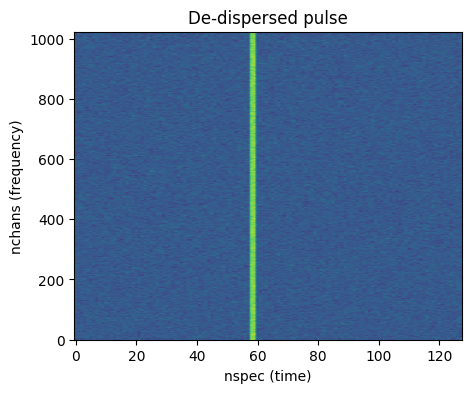

In [3]:
# Make an empty (zero) grid of shape (NCHANS, NSPEC)
shape = (NCHANS, NSPEC)
grid = np.zeros(shape)
signal_power = 10

# A pulse (de-dispersed) occurs in a random bin (spec)
random_bin = np.random.randint(0, NSPEC)
# random_bin = 20
print('Spec containing pulse:', random_bin)

# Add width to the pulse: ~ ms duration
pulse_left = int(random_bin-np.round(PULSE_WIDTH/2))
pulse_right = int(random_bin+np.round(PULSE_WIDTH/2))
grid[:, pulse_left:pulse_right] = signal_power

# Convolve the bin containing the signal with a gaussian function to get power smearing
mean = random_bin-0.5 # subtract 0.5 for center of bin
sigma = (PULSE_WIDTH)/2.35 # XXX FWHM?
def gaussian(xs, mean, sigma):
    return np.exp(-0.5*((xs-mean)**2)/(sigma**2))
gaussians = np.array([gaussian(spec, mean, sigma) for spec in range(NSPEC)])
for chan in range(NCHANS):
    for spec in range(NSPEC):
        grid[chan, spec] = gaussians[spec]*grid[chan, spec]

# Add Gaussian noise to entire grid
noise = np.random.randn(np.prod(shape)).reshape(shape)
grid = grid + noise

plt.figure(figsize=(5,4))
plt.imshow(grid, aspect='auto', origin='lower')
plt.xlabel('nspec (time)')
plt.ylabel('nchans (frequency)')
plt.title('De-dispersed pulse')
# plt.xlim(16,24)
# plt.vlines(pulse_left, 0, NCHANS, 'k')
# plt.vlines(pulse_right, 0, NCHANS, 'k')
# plt.margins(y=0)
# plt.grid()
plt.show()

In [4]:
def delay_time(DM, freq):
    const = 4140
    A = DM*const*1e3
    return A/(freq**2) # ms

td_0 = delay_time(DM, F_MAX)
tds = delay_time(DM, FREQS) - td_0
tds # ms

bins = tds/T_SAMP
round = np.round(bins).astype(int)

noise2 = np.random.randn(np.prod(shape)).reshape(shape)
for i in range(len(noise2)):
    idx = round[i]
    if idx >= NSPEC:
        continue
    noise2[i, idx] += signal_power
Image = noise2

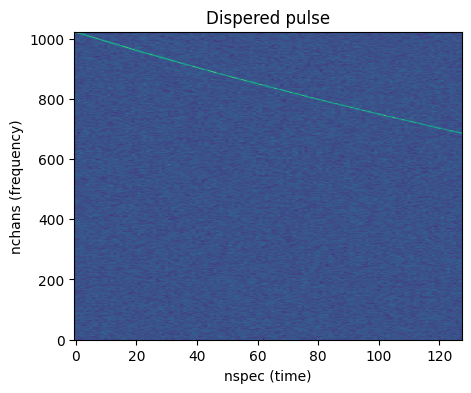

In [5]:
plt.figure(figsize=(5,4))
plt.imshow(Image, aspect='auto', origin='lower')
plt.title('Dispered pulse')
plt.xlabel('nspec (time)')
plt.ylabel('nchans (frequency)')
plt.show()

In [6]:
full_image = np.loadtxt('../data/mock_pulsar_data.txt', skiprows=1)
image = np.loadtxt('../data/mock_pulsar_data.txt', skiprows=1)[:, 1:]
image.shape

times = full_image[:, 0]
np.diff(times)[0]

0.008

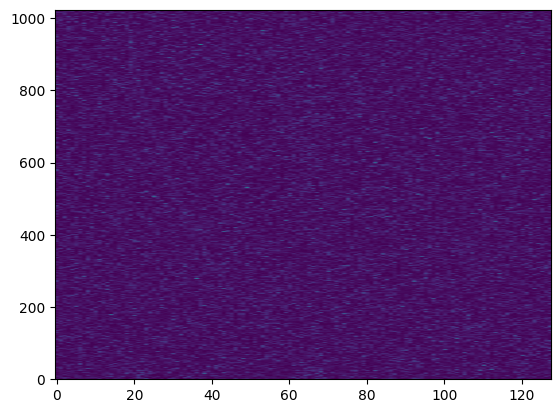

In [7]:
plt.imshow(image.T, aspect='auto', origin='lower')

In [139]:
def DM_delay(DM, freq):
    const = 4140
    A = DM*const*1e3
    return A/(freq**2)


def smearing(Power, nspec, pulse_width, t_samp):
    FWHM_frac = 2*np.sqrt(2*np.log(2))
    sigma = pulse_width/FWHM_frac
    smeared = np.empty_like(Power)
    for spec in range(nspec):
        freq = Power[:, spec]
        smeared[:, spec] = np.convolve(freq, signal.windows.gaussian(10, sigma/t_samp), mode='same')
    return smeared


def make_frb(nspec=128, nchans=1024, DM=332.72, pulse_width=2, f_min=1150, f_max=1650, t_samp=64e-3):
    shape = (nchans, nspec)
    freqs = np.linspace(f_min, f_max, nchans)
    t_min = 0
    t_max = t_samp*nspec
    times = np.linspace(t_min, t_max, nspec)
    signal_power = 10
    td0 = DM_delay(DM, f_max)
    tds = DM_delay(DM, freqs) - td0 
    bins = tds/t_samp
    rounded_bins = np.round(bins).astype(int)
    Image = np.random.randn(np.prod(shape)).reshape(shape)
    for i in range(len(Image)):
        index = rounded_bins[i]
        if index > nspec:
            continue
        Image[i, index] += signal_power
    return smearing(Image, nspec, pulse_width, t_samp)

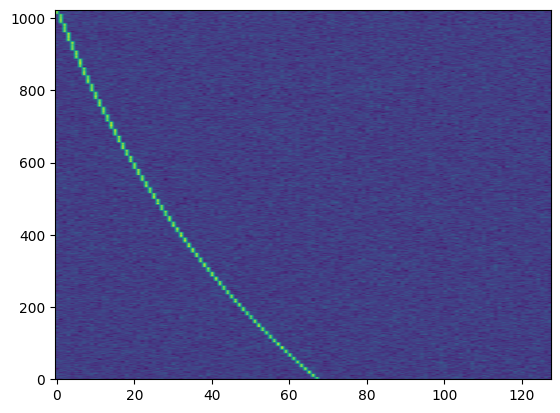

In [140]:
test = make_frb(DM=332.72, f_min=1150, f_max=1650, pulse_width=10, t_samp=8)
plt.imshow(test, aspect='auto', origin='lower')

In [134]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

td0 = DM_delay(DM, F_MAX)
tds = DM_delay(DM, FREQS) - td0 
bins = tds/T_SAMP
rounded_bins = np.round(bins).astype(int)
128/0.064

2000.0

AttributeError: Line2D.set() got an unexpected keyword argument 'mode'

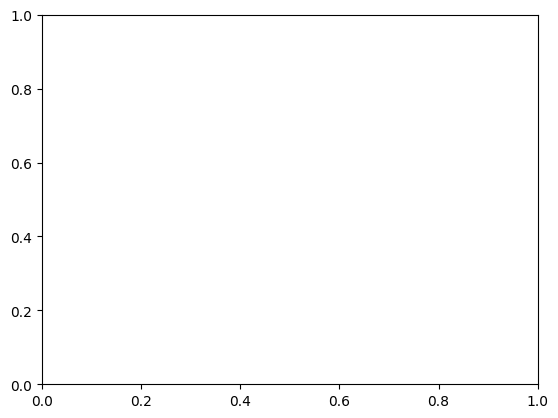

In [31]:
plt.plot(signal.windows.gaussian(10, (PULSE_WIDTH/2.35)/T_SAMP), mode='same')
# np.convolve?

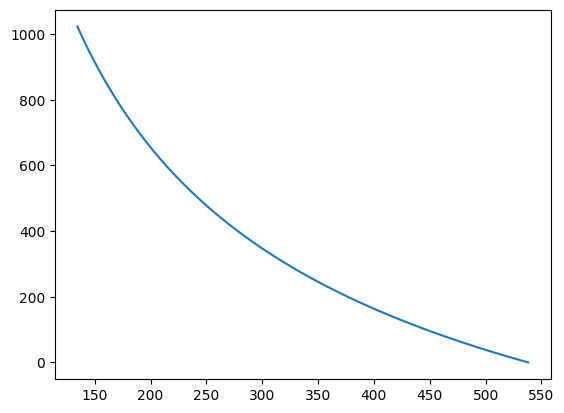

In [217]:
freqs = np.linspace(1000, 2000, 1024)
plt.plot(DM_delay(130, freqs), range(1024))

In [ ]:
64